## Test original Drivings

Imports

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
from scipy.sparse.linalg import eigsh
import qutip
from typing import List
from qutip import propagator
import os
from datetime import datetime
from scipy.sparse.linalg import eigsh,expm
from scipy.interpolate import interp1d
from src.tddft_methods.tddft_solver import Driving,second_derivative_formula


##### Info about the training dataset

In [278]:

data = np.load(
    "data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-07-18_15-21.npz"
)

print(data['info'])
print(data['comments'])
time=data['time']
h=data['h']

print(np.max(h),np.min(h))
print(np.average(h))

xx-z-x model with omega=1.0, coupling=-1.0 external field with rate min=0.0 and rate max=4.0 amplitude max=2.0 amplitude min=0.0 tf=30 steps=3000 l variable ndata=1000 initial state option=True pbc=True
fixed Initial state ground state, with a diagonostic is True dataset. 2nd order time derivative with9-points formula
2.501863825062358 0.0
0.9805937898782843


#### Set the driving

In [336]:
# if this is true, we are making datasets just to check the feasibility of the TDDFT method
diagnostic=True
derivative_formula='9-points' #it can be either 3-points,5-points,7-points,9-points

# parameters

nbatch = 1
batch_size =1

initial_state_ground_state=True
pbc=True
condition_initial_state='fixed'

# j coupling
j = -1
# omega auxiliary field
omega = 1

tf = 30

steps = 3000
steps_tddft=steps
final_steps= steps

dt=tf/steps



time = np.linspace(0.0, tf, steps)
time_tddft=np.linspace(0.0, tf, steps_tddft)
time_final=np.linspace(0.0, tf, final_steps)

l=8

In [357]:
h0=0.00*np.ones(l)
h1=1*np.ones(l)
t0=10
gamma=1
driving_type='impulse'

#### Compute the correct $h_{eff}$ and $z$

In [376]:
ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=pbc,
    coupling_values=[j],
    size=l,
    )

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    obs.append(z_op.qutip_op)


initial_value=np.random.uniform(-1,1)
if condition_initial_state=='variable':
    if initial_state_ground_state:
        hi=initial_value*np.ones((time.shape[0], l))
    else:
        hi=initial_value*np.zeros((time.shape[0], l))
elif condition_initial_state=='fixed':
    hi=initial_value*np.zeros((time.shape[0], l))

if driving_type=='quench':
    h=(h0[None,:])*np.exp(-gamma*time[:,None])+h1[None,:]*(1-np.exp(-gamma*time[:,None]))
elif driving_type=='periodic':
    h=h1[None,:]*(1+np.cos(np.pi+gamma*time[:,None]))

elif driving_type=='impulse':
    N = 10  # number of cosine terms
    omega0 = 1.0
    rates = np.linspace(0,4,N)
    a = np.exp(-1 * (rates-gamma)**2)  # example coefficients (Gaussian decay in freq)

    # Build the pulse
    pulse = np.zeros_like(time)
    for i in range(N):
        pulse += a[i] * (1+np.cos(np.pi + rates[i] * time))
    pulse/=N     
# Final driving
h = h0 + h1[None, :] * pulse[:, None]

hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

if initial_state_ground_state:
    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))


else:
    # we can build our own psi0
    psi_plus=qutip.basis(2,0)
    psi_minus=qutip.sigmam()*qutip.basis(2,0)
    
    p=np.random.uniform(0.,0.5,)

    
    for i in range(l):
        if i==0:
            psi0=psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus
        else:
            psi0=qutip.tensor(psi0,psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus)


hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

for i in range(l):
    drive_z = Driving(
        h=h,
        dt=time[1] - time[0],
        idx=i,
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution and

output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs )
#current_exp = np.zeros((steps, l))
z_exp = np.zeros((steps, l))

for r in range(l):
    z_exp[:, r] = output.expect[r]
    #current_exp[:, r] = output.expect[l + r]



# compute the effective field
psi=np.zeros((2,l))
psi[0] = np.sqrt((1 + z_exp[0]) / 2)
psi[1] = np.sqrt((1 - z_exp[0]) / 2)


# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


# extrapolate the fields
#f=interp1d(time,z_exp,axis=0)
#z_tddft=f(time_tddft)
z_tddft=z_exp
current_derivative_tddft=second_derivative_formula(z_tddft,dt=time_tddft[1]-time_tddft[0],derivative_formula=derivative_formula)



dt=time_tddft[1]-time_tddft[0]    

z_reconstruction=np.zeros((steps_tddft,l))
h_eff_vector=np.zeros((steps_tddft,l))
for i in trange(steps_tddft):
    psi_r=psi.copy()
    for f in range(1):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
        z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
        
        if pbc:
            #pbc
            nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
        
        else:
            #obc
            shift_plus=np.zeros(l)
            shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
            shift_minus=np.zeros(l)
            shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
            #print(shift_minus,shift_plus)
            nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega+10**-10
        h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
        h_eff_vector[i]=h_eff
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
        psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
        
        
    psi=np.einsum('lab,bl->al',exp_h_t,psi)
    psi=psi/np.linalg.norm(psi,axis=0)
    
    z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)



  0%|          | 0/3000 [00:00<?, ?it/s]/tmp/ipykernel_789085/1748167142.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_789085/1748167142.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  h_eff_vector[i]=h_eff
100%|██████████| 3000/3000 [00:04<00:00, 655.27it/s]


##### Visualize the results

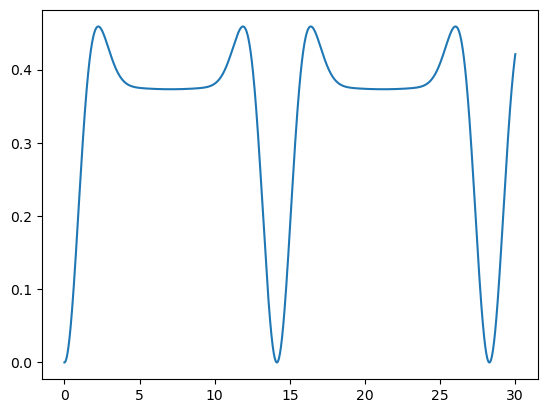

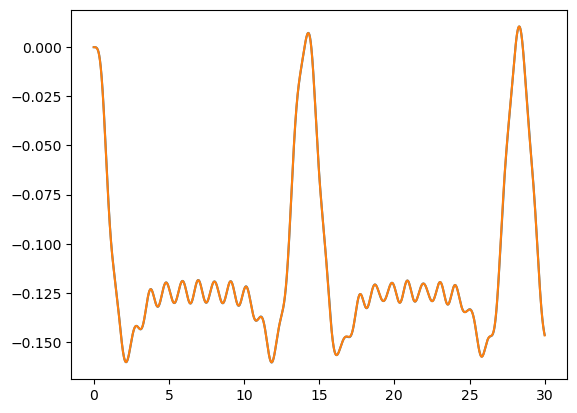

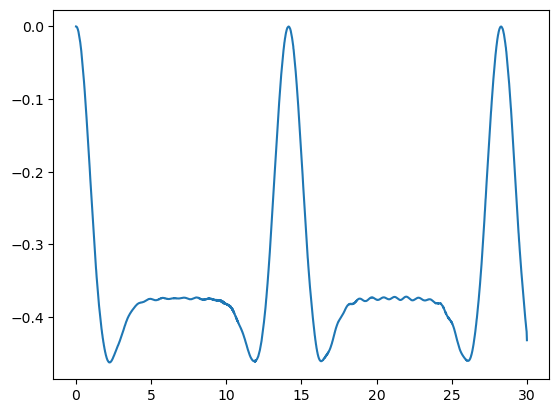

In [377]:
plt.plot(time,h[:,0])
plt.show()


plt.plot(time,z_exp[:,0])
plt.plot(time,z_reconstruction[:,0])
plt.show()

plt.plot(time,h_eff_vector[:,0])
plt.show()

#### Predict the $h_{eff}$

In [212]:
import torch

Load the model

In [378]:
labels=[r'$\tau J=10$']
models=[]
models_name=['dataset_2025-06-30_13-44_LSTM_f2f_fixed_initial_state_tf_10_nsteps_1000_250708_dataset_30k_[200]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
#models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/"+name,
    map_location="cpu",
    weights_only=False
    )
    model.eval()
    models.append(model)
    print(model)

BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)


In [ ]:
print(h.shape)
model.eval()
input=np.append(np.zeros(l)[None,:],h,axis=0) # batch_dim x time x 1
h_eff_predict=model(torch.from_numpy(input[:,:1]).unsqueeze(0)).squeeze().detach().numpy()[1:]

print(h_eff_predict.shape)

(3000, 8)
(3000,)


##### Check the predicted h_eff

(Optional) filter for unphysical frequencies

In [380]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq

# Parameters
dt = time[1] - time[0]  # Sampling interval
freqs = fftfreq(len(h_eff_predict), d=dt)
cutoff = 5  # Choose a cutoff frequency depending on your time units

# FFT
fft_vals = fft(h_eff_predict)
# Zero out high frequencies
fft_vals[np.abs(freqs) > cutoff] = 0
# Inverse FFT
h_eff_filtered = np.real(ifft(fft_vals))

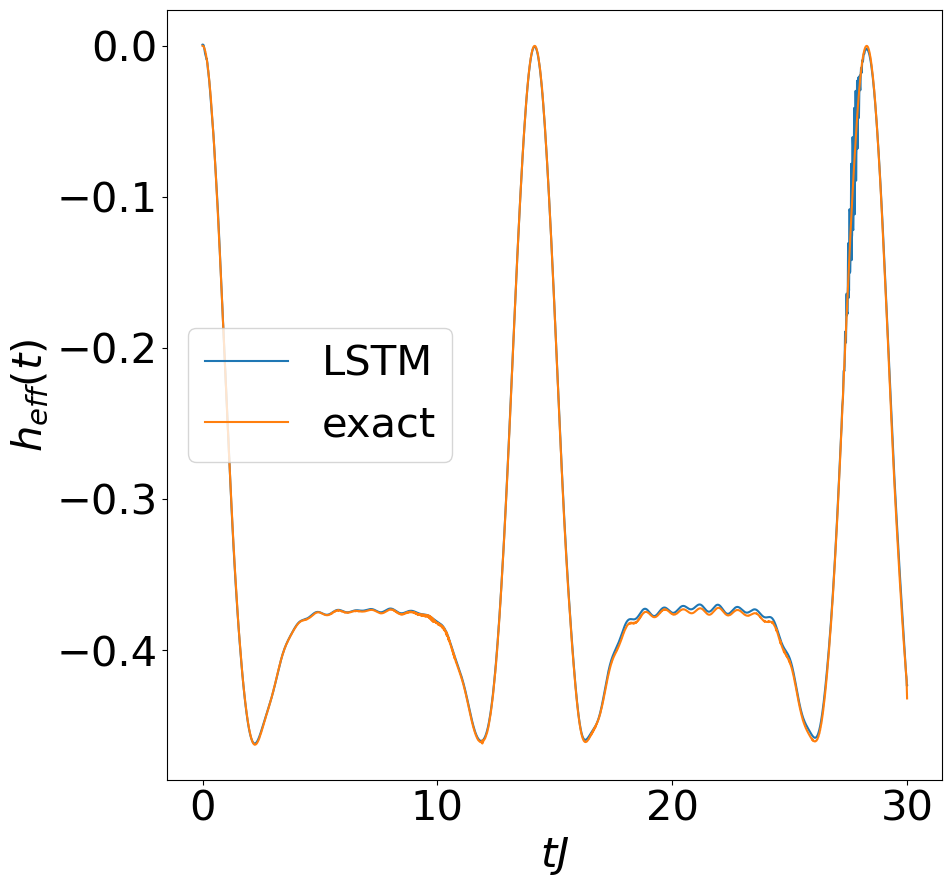

In [381]:
plt.figure(figsize=(10,10))
plt.plot(time,h_eff_predict,label='LSTM')
#plt.plot(time,h_eff_filtered,label='LSTM filtered')
plt.plot(time,h_eff_vector[:,0],label='exact')
plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$h_{eff}(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

Signal

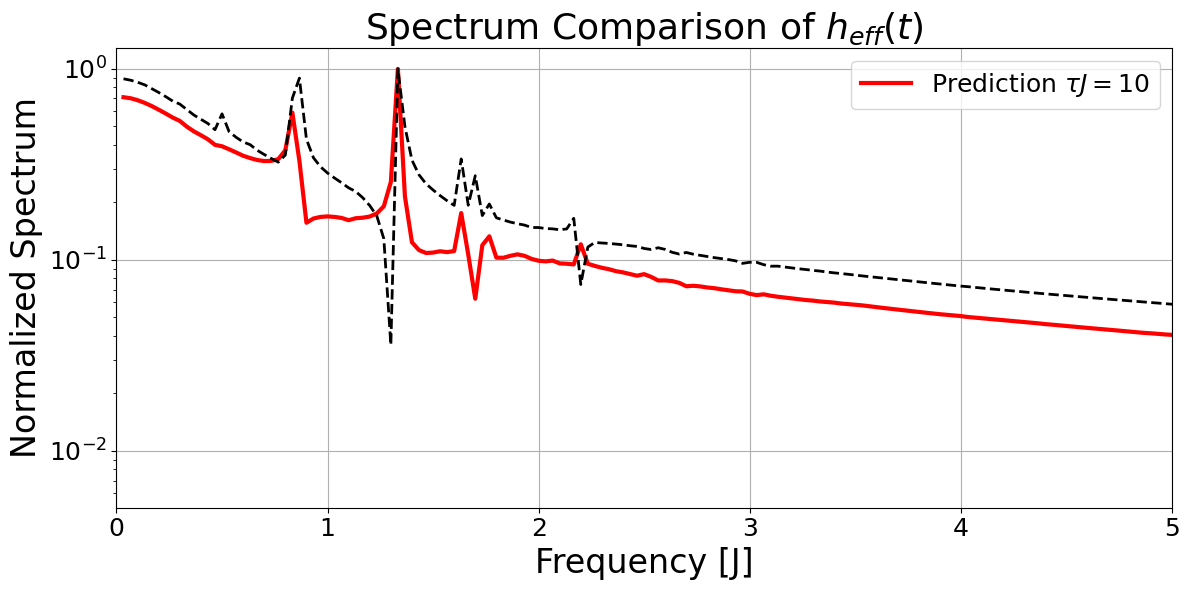

In [309]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# Sampling info
dt = time[1] - time[0]  # time step
fs = 1.0 / dt           # sampling frequency
N = len(time)           # number of time points

# Signal index to analyze

j = 0  # assuming we still look at j=0

plt.figure(figsize=(12, 6))
fft_predsictions = []

# Signals
true_signal = h_eff_vector[:,0]
pred_signal = h_eff_predict[:]

# Compute FFT
fft_true = np.abs(fft(true_signal - np.mean(true_signal)))
fft_pred = np.abs(fft(pred_signal - np.mean(pred_signal)))

freqs = fftfreq(len(true_signal), d=dt)

# Keep only positive frequencies
mask = freqs > 0
freqs = freqs[mask]
fft_true = fft_true[mask]
fft_pred = fft_pred[mask]

# Normalize (optional but good for visualization)
fft_true /= np.max(fft_true)
fft_pred /= np.max(fft_pred)

# Plot
plt.plot(freqs, fft_pred, label=f'Prediction {labels[i]}', linewidth=3, color='red')
plt.plot(freqs, fft_true, '--', color='black', linewidth=2)
fft_predsictions.append(fft_pred)
plt.xlabel('Frequency [J]', fontsize=24)
plt.ylabel('Normalized Spectrum', fontsize=24)
plt.title('Spectrum Comparison of $h_{eff}(t)$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.yscale('log')  # Show smaller peaks better
plt.xlim([0, 5])   # Zoom in on frequency range
plt.tight_layout()
plt.show()

##### Analysis of the peaks

In [158]:
from scipy.signal import find_peaks

# Example: assuming `fft_true` contains the normalized FFT magnitude (1D array),
# and `freqs` contains the corresponding frequency values

# Find peaks in the FFT spectrum (adjust `height` as needed)
peaks, properties = find_peaks(fft_true, height=0.1)

# Extract frequencies and corresponding peak heights
important_freqs = freqs[peaks]
peak_heights = properties['peak_heights']

# Sort peaks by height (descending)
sorted_indices = peak_heights.argsort()[::-1]

# Select top N dominant frequencies
top_n = 20
top_freqs = important_freqs[sorted_indices][:top_n]
top_heights = peak_heights[sorted_indices][:top_n]

# Print the top dominant frequencies
exact_freqs = freqs[peaks][sorted_indices][:top_n]
exact_heights = properties['peak_heights'][sorted_indices][:top_n]
for i, (f, h) in enumerate(zip(top_freqs, top_heights)):
    print(f"Peak {i+1}: Frequency = {f:.4f} J, Normalized Amplitude = {h:.3f}")

Peak 1: Frequency = 0.7664 J, Normalized Amplitude = 1.000
Peak 2: Frequency = 1.4662 J, Normalized Amplitude = 0.993
Peak 3: Frequency = 1.9993 J, Normalized Amplitude = 0.813
Peak 4: Frequency = 1.6661 J, Normalized Amplitude = 0.689
Peak 5: Frequency = 0.6664 J, Normalized Amplitude = 0.462
Peak 6: Frequency = 0.5332 J, Normalized Amplitude = 0.332
Peak 7: Frequency = 0.8997 J, Normalized Amplitude = 0.179
Peak 8: Frequency = 0.9997 J, Normalized Amplitude = 0.132
Peak 9: Frequency = 2.2326 J, Normalized Amplitude = 0.129
Peak 10: Frequency = 1.5995 J, Normalized Amplitude = 0.128
Peak 11: Frequency = 2.4658 J, Normalized Amplitude = 0.123
Peak 12: Frequency = 1.1996 J, Normalized Amplitude = 0.118
Peak 13: Frequency = 2.5991 J, Normalized Amplitude = 0.118
Peak 14: Frequency = 1.1330 J, Normalized Amplitude = 0.116
Peak 15: Frequency = 1.3329 J, Normalized Amplitude = 0.112


In [159]:
from scipy.signal import find_peaks

# Example: assuming `fft_true` contains the normalized FFT magnitude (1D array),
# and `freqs` contains the corresponding frequency values
predict_freqs_predictions = []
predict_heights_predictions = []
for fft_pred in fft_predsictions:
    # Find peaks in the FFT spectrum (adjust `height` as needed)
    peaks, properties = find_peaks(fft_pred, height=0.1)

    # Extract frequencies and corresponding peak heights
    important_freqs = freqs[peaks]
    peak_heights = properties['peak_heights']

    # Sort peaks by height (descending)
    sorted_indices = peak_heights.argsort()[::-1]

    # Select top N dominant frequencies

    top_freqs = important_freqs[sorted_indices][:top_n]
    top_heights = peak_heights[sorted_indices][:top_n]

    predict_freqs = freqs[peaks][sorted_indices][:top_n]
    predict_heights = properties['peak_heights'][sorted_indices][:top_n]

    predict_freqs_predictions.append(predict_freqs)
    predict_heights_predictions.append(predict_heights)
    # Print the top dominant frequencies
    for i, (f, h) in enumerate(zip(top_freqs, top_heights)):
        print(f"Peak {i+1}: Frequency = {f:.4f} J, Normalized Amplitude = {h:.3f}")

Peak 1: Frequency = 0.7664 J, Normalized Amplitude = 1.000
Peak 2: Frequency = 1.6994 J, Normalized Amplitude = 0.961
Peak 3: Frequency = 1.9993 J, Normalized Amplitude = 0.796
Peak 4: Frequency = 1.4329 J, Normalized Amplitude = 0.755
Peak 5: Frequency = 0.1666 J, Normalized Amplitude = 0.505
Peak 6: Frequency = 1.5661 J, Normalized Amplitude = 0.454
Peak 7: Frequency = 0.6664 J, Normalized Amplitude = 0.427
Peak 8: Frequency = 1.9327 J, Normalized Amplitude = 0.399
Peak 9: Frequency = 0.4665 J, Normalized Amplitude = 0.363
Peak 10: Frequency = 2.1326 J, Normalized Amplitude = 0.305
Peak 11: Frequency = 1.6328 J, Normalized Amplitude = 0.290
Peak 12: Frequency = 1.8327 J, Normalized Amplitude = 0.199
Peak 13: Frequency = 1.0330 J, Normalized Amplitude = 0.197
Peak 14: Frequency = 2.2992 J, Normalized Amplitude = 0.153
Peak 15: Frequency = 1.1330 J, Normalized Amplitude = 0.141
Peak 16: Frequency = 2.3992 J, Normalized Amplitude = 0.126
Peak 17: Frequency = 2.7991 J, Normalized Amplitu

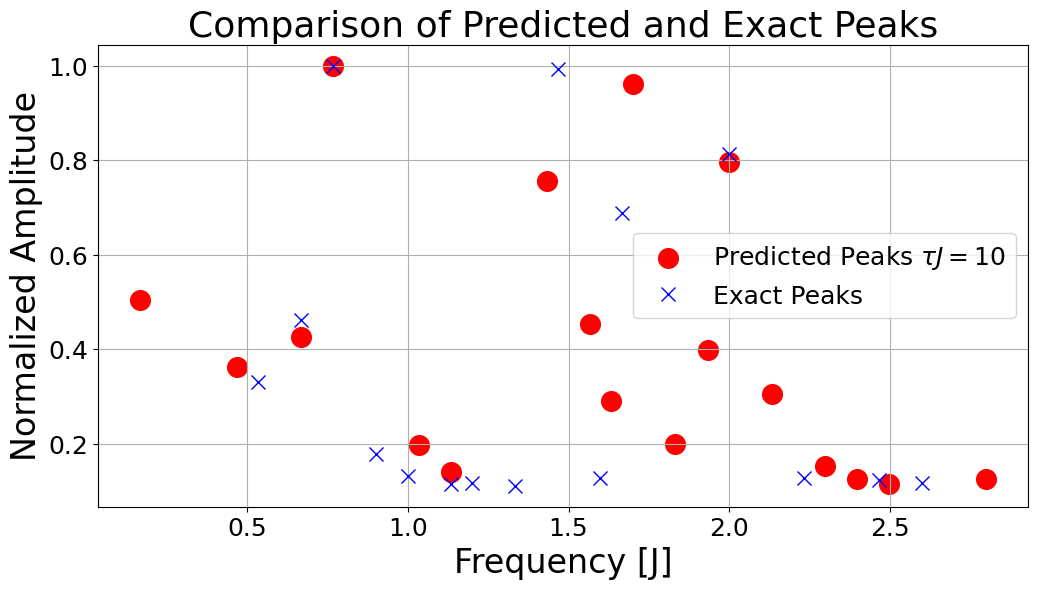

In [160]:
plt.figure(figsize=(12, 6))
markers = ['o', 's', 'D', '^', 'v']
# Plot the FFT spectrum with peaks
for i, (predict_freqs, predict_heights) in enumerate(zip(predict_freqs_predictions, predict_heights_predictions)):
    plt.scatter(predict_freqs, predict_heights,marker='o', label=f'Predicted Peaks {labels[i]}', color='red',s=200)

plt.plot(exact_freqs, exact_heights, 'x', label='Exact Peaks', color='blue',markersize=10)
plt.xlabel('Frequency [J]', fontsize=24)
plt.ylabel('Normalized Amplitude', fontsize=24)
plt.title('Comparison of Predicted and Exact Peaks', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.grid(True)  
plt.show()

#### Systematic Analysis

In [463]:
gammas=np.linspace(0.1,4,20)
h0=0.*np.ones(l)
h1=1*np.ones(l)
driving_type='quench'


In [468]:
h_eff_predictions=[]
h_eff_exacts=[]


for gamma in gammas:
    # if this is true, we are making datasets just to check the feasibility of the TDDFT method
    diagnostic=True
    derivative_formula='9-points' #it can be either 3-points,5-points,7-points,9-points

    # parameters

    nbatch = 1
    batch_size =1

    initial_state_ground_state=True
    pbc=True
    condition_initial_state='fixed'

    # j coupling
    j = -1
    # omega auxiliary field
    omega = 1

    tf = 25

    steps = 2500
    steps_tddft=steps
    final_steps= steps

    dt=tf/steps



    time = np.linspace(0.0, tf, steps)
    time_tddft=np.linspace(0.0, tf, steps_tddft)
    time_final=np.linspace(0.0, tf, final_steps)
    
    ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=pbc,
    coupling_values=[j],
    size=l,
    )

    hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

    obs: List[qutip.Qobj] = []

    for i in range(l):
        z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
        obs.append(z_op.qutip_op)


    initial_value=np.random.uniform(-1,1)
    if condition_initial_state=='variable':
        if initial_state_ground_state:
            hi=initial_value*np.ones((time.shape[0], l))
        else:
            hi=initial_value*np.zeros((time.shape[0], l))
    elif condition_initial_state=='fixed':
        hi=initial_value*np.zeros((time.shape[0], l))

    if driving_type=='quench':
        h=(h0[None,:])*np.exp(-gamma*time[:,None])+h1[None,:]*(1-np.exp(-gamma*time[:,None]))
    elif driving_type=='periodic':
        h=h1[None,:]*(1+np.cos(np.pi+gamma*time[:,None]))

    elif driving_type=='impulse':
        N = 10  # number of cosine terms
        omega0 = 1.0
        rates = np.linspace(0,4,N)
        a = np.exp(-1 * (rates-gamma)**2)  # example coefficients (Gaussian decay in freq)

        # Build the pulse
        pulse = np.zeros_like(time)
        for i in range(N):
            pulse += a[i] * (1+np.cos(np.pi + rates[i] * time))
        pulse/=N     
        # Final driving
        h = h0 + h1[None, :] * pulse[:, None]

    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    if initial_state_ground_state:
        eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
            eigvals=1
        )
        psi0 = psi0[
            0
        ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))


    else:
        # we can build our own psi0
        psi_plus=qutip.basis(2,0)
        psi_minus=qutip.sigmam()*qutip.basis(2,0)
        
        p=np.random.uniform(0.,0.5,)

        
        for i in range(l):
            if i==0:
                psi0=psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus
            else:
                psi0=qutip.tensor(psi0,psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus)


    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs )
    #current_exp = np.zeros((steps, l))
    z_exp = np.zeros((steps, l))

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        #current_exp[:, r] = output.expect[l + r]



    # compute the effective field
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z_exp[0]) / 2)
    psi[1] = np.sqrt((1 - z_exp[0]) / 2)


    # build up the operators
    x_op=np.array([[0.,1.],[1.,0]])
    z_op=np.array([[1.,0.],[0.,-1.]])


    # extrapolate the fields
    #f=interp1d(time,z_exp,axis=0)
    #z_tddft=f(time_tddft)
    z_tddft=z_exp
    current_derivative_tddft=second_derivative_formula(z_tddft,dt=time_tddft[1]-time_tddft[0],derivative_formula=derivative_formula)



    dt=time_tddft[1]-time_tddft[0]    

    z_reconstruction=np.zeros((steps_tddft,l))
    h_eff_vector=np.zeros((steps_tddft,l))
    for i in trange(steps_tddft):
        psi_r=psi.copy()
        for f in range(1):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
            z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
            
            if pbc:
                #pbc
                nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            else:
                #obc
                shift_plus=np.zeros(l)
                shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
                shift_minus=np.zeros(l)
                shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
                #print(shift_minus,shift_plus)
                nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega+10**-10
            h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
            h_eff_vector[i]=h_eff
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
            psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
            
            
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
        
    labels=[r'$\tau J=10$']
    models=[]
    models_name=['dataset_2025-06-30_13-44_LSTM_f2f_fixed_initial_state_tf_10_nsteps_1000_250708_dataset_30k_[200]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
    #models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
    for i,name in enumerate(models_name):
        model = torch.load(
        "model_rep/"+name,
        map_location="cpu",
        weights_only=False
        )
        model.eval()
        models.append(model)
        print(model)
        
        print(h.shape)
    model.eval()
    input=np.append(np.zeros(l)[None,:],h,axis=0) # batch_dim x time x 1
    h_eff_predict=model(torch.from_numpy(input[:,:1]).unsqueeze(0)).squeeze().detach().numpy()[1:]

    print(h_eff_predict.shape)
    
    h_eff_predictions.append(h_eff_predict)
    h_eff_exacts.append(h_eff_vector)
        

  0%|          | 0/2500 [00:00<?, ?it/s]/tmp/ipykernel_789085/1886366546.py:187: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_789085/1886366546.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  h_eff_vector[i]=h_eff
100%|██████████| 2500/2500 [00:04<00:00, 583.83it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 600.37it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:03<00:00, 633.94it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 573.47it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 598.57it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 537.83it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 569.26it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 597.55it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 572.75it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 606.66it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 582.22it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 564.29it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 544.52it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 526.56it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 537.27it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 595.86it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 569.18it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 608.26it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 573.35it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


100%|██████████| 2500/2500 [00:04<00:00, 610.90it/s]


BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)
(2500, 8)
(2500,)


In [469]:
for i in range(len(h_eff_predictions)):
    h_eff_predict=h_eff_predictions[i]
    h_eff_vector=h_eff_exacts[i]
    plt.figure(figsize=(10,10))
    plt.plot(time,h_eff_predict,label='LSTM')
    #plt.plot(time,h_eff_filtered,label='LSTM filtered')
    plt.plot(time,h_eff_vector[:,0],label='exact')
    plt.xlabel(r'$tJ$',fontsize=30)
    plt.ylabel(r'$h_{eff}(t)$',fontsize=30)
    plt.legend(fontsize=30)
    plt.tick_params(labelsize=30)
    plt.show()

2.1526315789473687


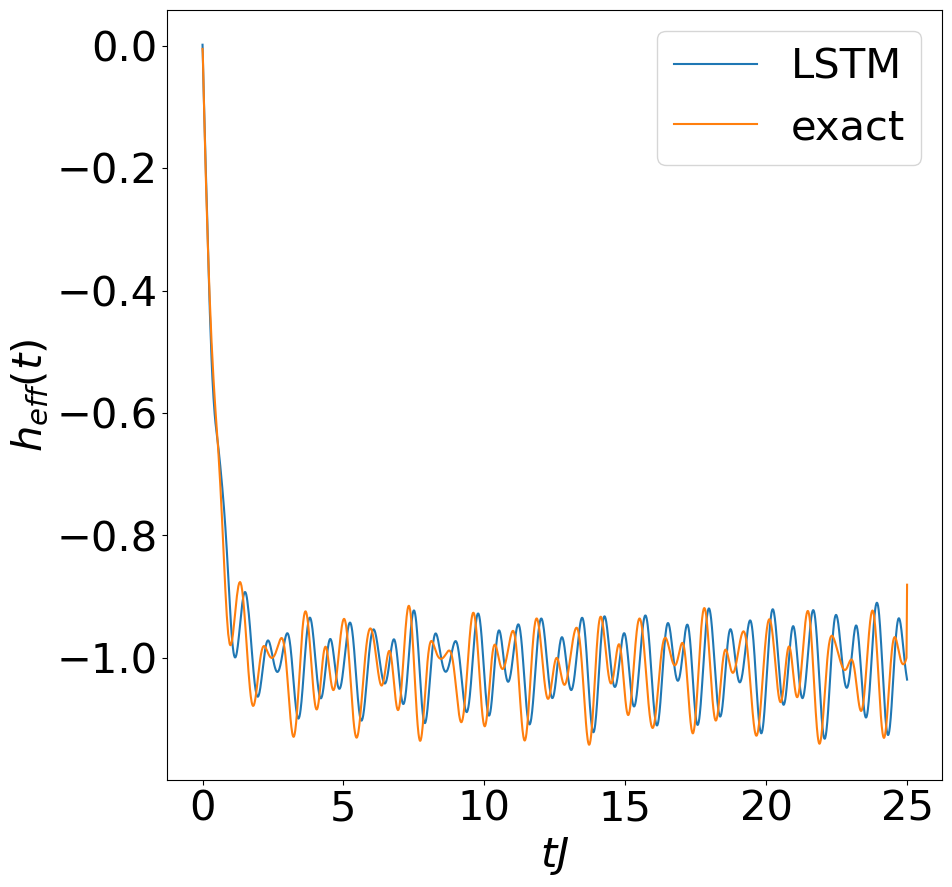

In [470]:
idx=10
print(gammas[idx])
h_eff_predict=h_eff_predictions[idx]
h_eff_vector=h_eff_exacts[idx]
plt.figure(figsize=(10,10))
plt.plot(time,h_eff_predict,label='LSTM')
#plt.plot(time,h_eff_filtered,label='LSTM filtered')
plt.plot(time,h_eff_vector[:,0],label='exact')
plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$h_{eff}(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

In [471]:
h_eff_predictions=np.asarray(h_eff_predictions)
h_eff_exacts=np.asarray(h_eff_exacts)[:,:,0]

In [472]:

print(h_eff_exacts.shape,h_eff_predictions.shape)
dh_eff=(np.average(np.abs(h_eff_predictions-h_eff_exacts)/(np.max(h_eff_exacts,axis=1)-np.min(h_eff_exacts,axis=1))[:,None],axis=-1))#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)

(20, 2500) (20, 2500)


2.1526315789473687


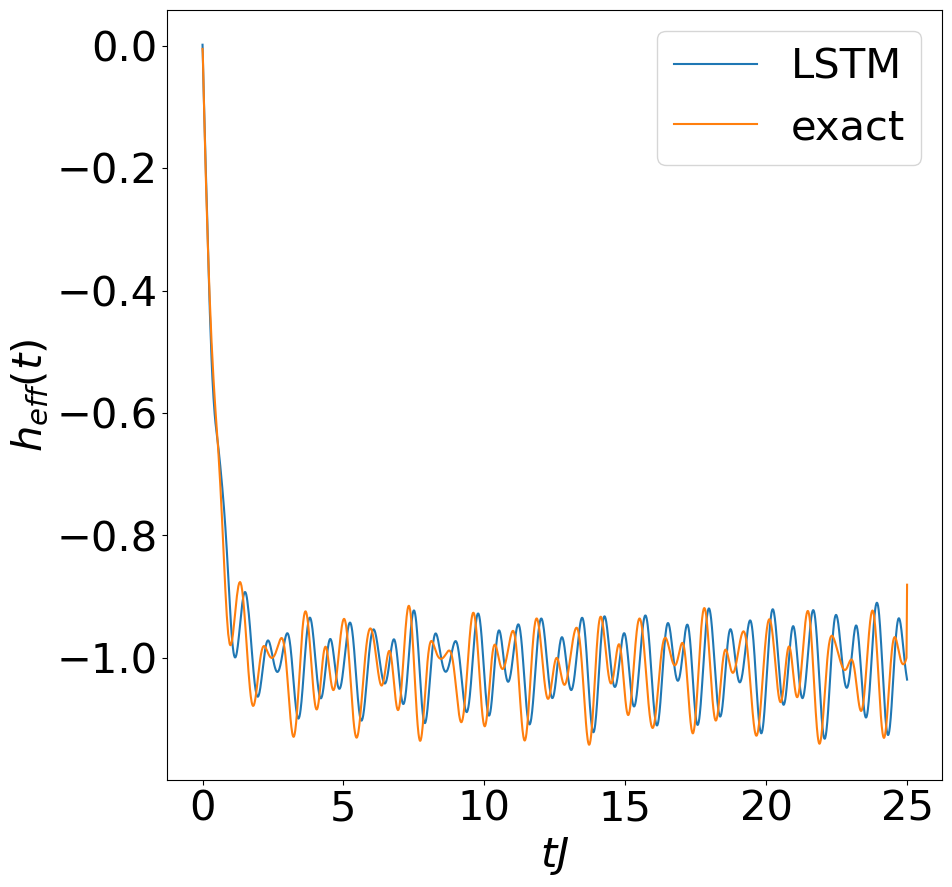

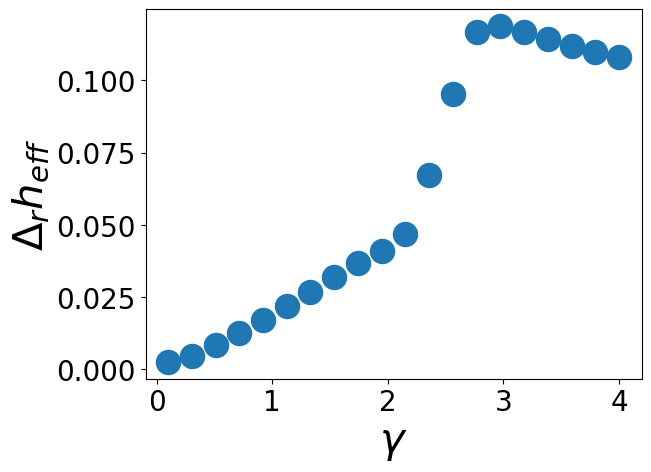

In [473]:
idx=10
print(gammas[idx])
h_eff_predict=h_eff_predictions[idx]
h_eff_vector=h_eff_exacts[idx]
plt.figure(figsize=(10,10))
plt.plot(time,h_eff_predict,label='LSTM')
#plt.plot(time,h_eff_filtered,label='LSTM filtered')
plt.plot(time,h_eff_vector,label='exact')
plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$h_{eff}(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()


plt.scatter(gammas,dh_eff,s=300,marker='o')
plt.xlabel(r'$\gamma$',fontsize=30)
plt.ylabel(r'$\Delta_r h_{eff}$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

2.1526315789473687


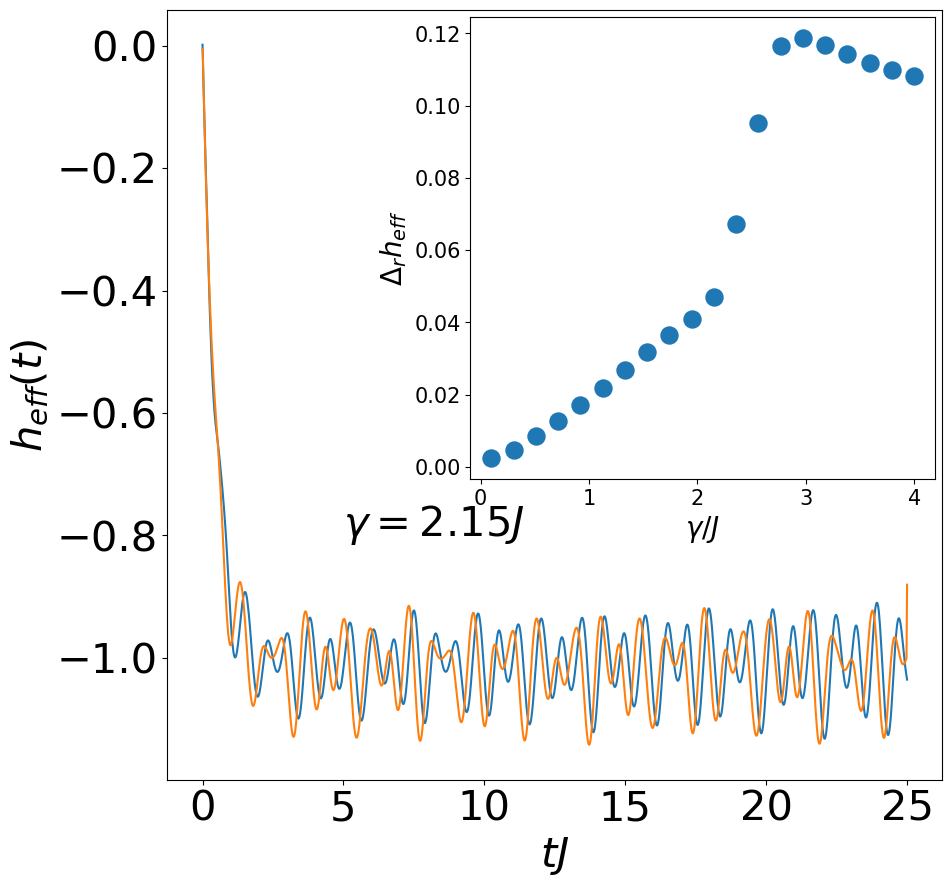

In [475]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

idx = 10
print(gammas[idx])
h_eff_predict = h_eff_predictions[idx]
h_eff_vector = h_eff_exacts[idx]

# Main plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(time, h_eff_predict, label='LSTM')
ax.plot(time, h_eff_vector, label='exact')
ax.set_xlabel(r'$tJ$', fontsize=30)
ax.set_ylabel(r'$h_{eff}(t)$', fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(labelsize=30)
ax.text(x=5,y=-0.8,s=r'$\gamma=2.15 J$',fontsize=30)
# Larger inset plot
inset_ax = inset_axes(ax, width="60%", height="60%", loc='upper right')  # Increase size
inset_ax.scatter(gammas, dh_eff, s=150, marker='o')
inset_ax.set_xlabel(r'$\gamma/J$', fontsize=20)
inset_ax.set_ylabel(r'$\Delta_r h_{eff}$', fontsize=20)
inset_ax.tick_params(labelsize=15)

plt.show()

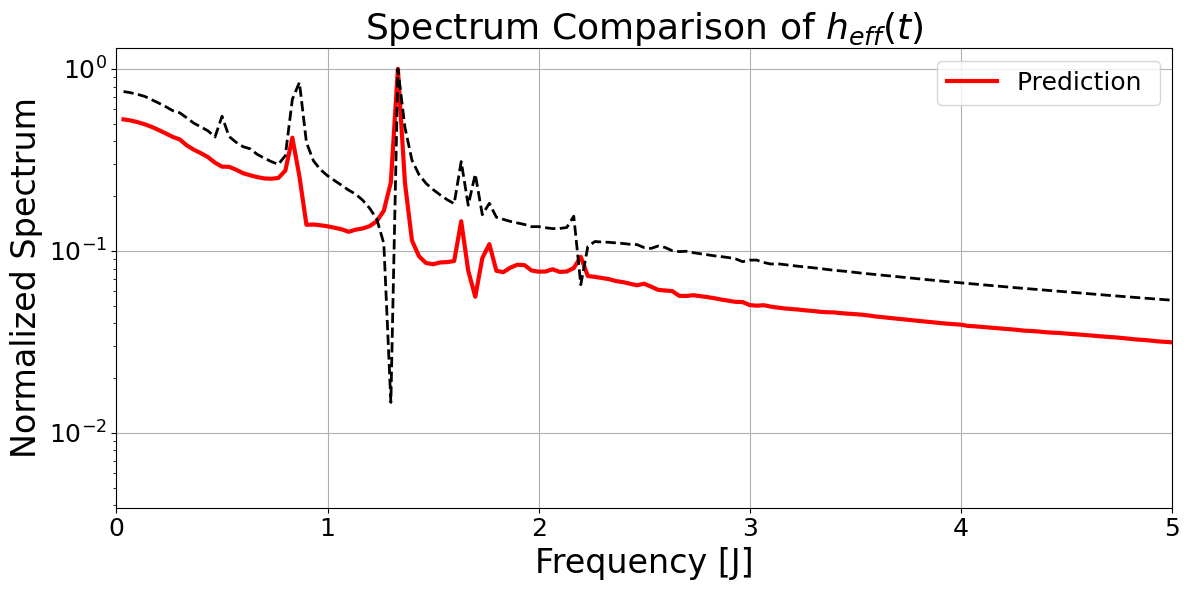

In [450]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# Sampling info
dt = time[1] - time[0]  # time step
fs = 1.0 / dt           # sampling frequency
N = len(time)           # number of time points

# Signal index to analyze

j = 0  # assuming we still look at j=0

plt.figure(figsize=(12, 6))
fft_predsictions = []

# Signals
true_signal = h_eff_vector[:]
pred_signal = h_eff_predict[:]

# Compute FFT
fft_true = np.abs(fft(true_signal - np.mean(true_signal)))
fft_pred = np.abs(fft(pred_signal - np.mean(pred_signal)))

freqs = fftfreq(len(true_signal), d=dt)

# Keep only positive frequencies
mask = freqs > 0
freqs = freqs[mask]
fft_true = fft_true[mask]
fft_pred = fft_pred[mask]

# Normalize (optional but good for visualization)
fft_true /= np.max(fft_true)
fft_pred /= np.max(fft_pred)

# Plot
plt.plot(freqs, fft_pred, label=f'Prediction ', linewidth=3, color='red')
plt.plot(freqs, fft_true, '--', color='black', linewidth=2)
fft_predsictions.append(fft_pred)
plt.xlabel('Frequency [J]', fontsize=24)
plt.ylabel('Normalized Spectrum', fontsize=24)
plt.title('Spectrum Comparison of $h_{eff}(t)$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.yscale('log')  # Show smaller peaks better
plt.xlim([0, 5])   # Zoom in on frequency range
plt.tight_layout()
plt.show()

In [451]:
from scipy.signal import find_peaks

# Example: assuming `fft_true` contains the normalized FFT magnitude (1D array),
# and `freqs` contains the corresponding frequency values

# Find peaks in the FFT spectrum (adjust `height` as needed)
peaks, properties = find_peaks(fft_true, height=0.05)

# Extract frequencies and corresponding peak heights
important_freqs = freqs[peaks]
peak_heights = properties['peak_heights']

# Sort peaks by height (descending)
sorted_indices = peak_heights.argsort()[::-1]

# Select top N dominant frequencies
top_n = 10
top_freqs = important_freqs[sorted_indices][:top_n]
top_heights = peak_heights[sorted_indices][:top_n]

# Print the top dominant frequencies
exact_freqs = freqs[peaks][sorted_indices][:top_n]
exact_heights = properties['peak_heights'][sorted_indices][:top_n]
for i, (f, h) in enumerate(zip(top_freqs, top_heights)):
    print(f"Peak {i+1}: Frequency = {f:.4f} J, Normalized Amplitude = {h:.3f}")

Peak 1: Frequency = 1.3329 J, Normalized Amplitude = 1.000
Peak 2: Frequency = 0.8664 J, Normalized Amplitude = 0.843
Peak 3: Frequency = 0.4998 J, Normalized Amplitude = 0.549
Peak 4: Frequency = 1.6328 J, Normalized Amplitude = 0.309
Peak 5: Frequency = 1.6994 J, Normalized Amplitude = 0.264
Peak 6: Frequency = 1.7661 J, Normalized Amplitude = 0.183
Peak 7: Frequency = 2.1659 J, Normalized Amplitude = 0.155
Peak 8: Frequency = 1.9993 J, Normalized Amplitude = 0.136
Peak 9: Frequency = 2.2659 J, Normalized Amplitude = 0.113
Peak 10: Frequency = 2.5658 J, Normalized Amplitude = 0.106


In [452]:
from scipy.signal import find_peaks

# Example: assuming `fft_true` contains the normalized FFT magnitude (1D array),
# and `freqs` contains the corresponding frequency values

# Find peaks in the FFT spectrum (adjust `height` as needed)
peaks, properties = find_peaks(fft_pred, height=0.05)

# Extract frequencies and corresponding peak heights
important_freqs = freqs[peaks]
peak_heights = properties['peak_heights']

# Sort peaks by height (descending)
sorted_indices = peak_heights.argsort()[::-1]

# Select top N dominant frequencies

top_freqs = important_freqs[sorted_indices][:top_n]
top_heights = peak_heights[sorted_indices][:top_n]

predict_freqs = freqs[peaks][sorted_indices][:top_n]
predict_heights = properties['peak_heights'][sorted_indices][:top_n]


# Print the top dominant frequencies
for i, (f, h) in enumerate(zip(top_freqs, top_heights)):
    print(f"Peak {i+1}: Frequency = {f:.4f} J, Normalized Amplitude = {h:.3f}")

Peak 1: Frequency = 1.3329 J, Normalized Amplitude = 1.000
Peak 2: Frequency = 0.8331 J, Normalized Amplitude = 0.419
Peak 3: Frequency = 1.6328 J, Normalized Amplitude = 0.146
Peak 4: Frequency = 0.9330 J, Normalized Amplitude = 0.140
Peak 5: Frequency = 1.7661 J, Normalized Amplitude = 0.109
Peak 6: Frequency = 2.1993 J, Normalized Amplitude = 0.093
Peak 7: Frequency = 1.8994 J, Normalized Amplitude = 0.084
Peak 8: Frequency = 2.0660 J, Normalized Amplitude = 0.079
Peak 9: Frequency = 2.4992 J, Normalized Amplitude = 0.066
Peak 10: Frequency = 2.7324 J, Normalized Amplitude = 0.057


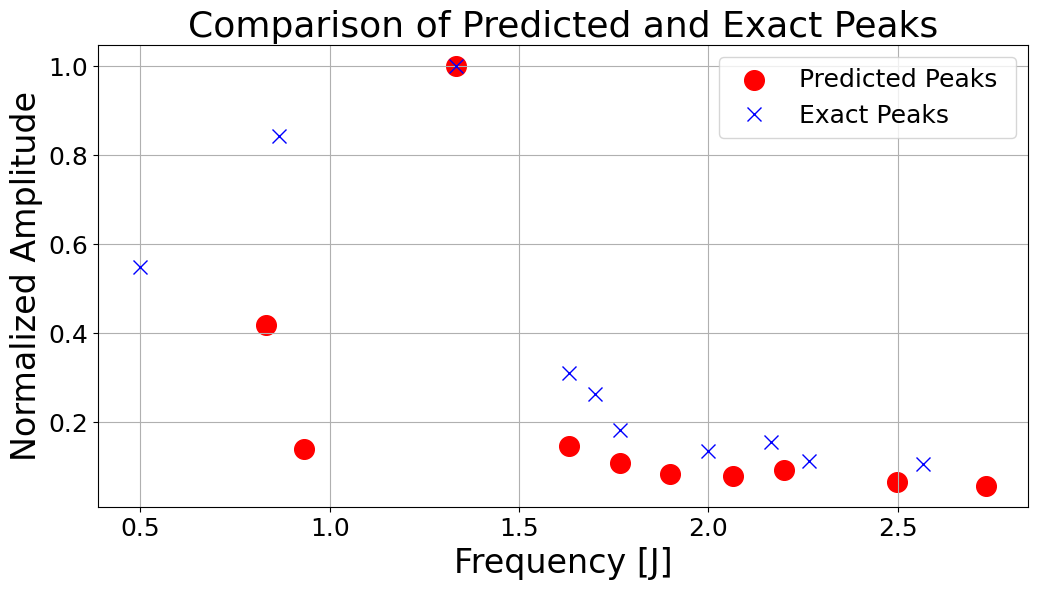

In [453]:
plt.figure(figsize=(12, 6))
markers = ['o', 's', 'D', '^', 'v']
# Plot the FFT spectrum with peaks

plt.scatter(predict_freqs, predict_heights,marker='o', label=f'Predicted Peaks ', color='red',s=200)

plt.plot(exact_freqs, exact_heights, 'x', label='Exact Peaks', color='blue',markersize=10)
plt.xlabel('Frequency [J]', fontsize=24)
plt.ylabel('Normalized Amplitude', fontsize=24)
plt.title('Comparison of Predicted and Exact Peaks', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.grid(True)  
plt.show()

#### Test with the periodic field

In [492]:
gammas=np.linspace(0.1,4,20)
h0=1.*np.ones(l)
h1=0.5*np.ones(l)
driving_type='periodic'

In [ ]:
h_eff_predictions=[]
h_eff_exacts=[]


for gamma in gammas:
    # if this is true, we are making datasets just to check the feasibility of the TDDFT method
    diagnostic=True
    derivative_formula='9-points' #it can be either 3-points,5-points,7-points,9-points

    # parameters

    nbatch = 1
    batch_size =1

    initial_state_ground_state=True
    pbc=True
    condition_initial_state='fixed'

    # j coupling
    j = -1
    # omega auxiliary field
    omega = 1

    tf = 25

    steps = 2500
    steps_tddft=steps
    final_steps= steps

    dt=tf/steps



    time = np.linspace(0.0, tf, steps)
    time_tddft=np.linspace(0.0, tf, steps_tddft)
    time_final=np.linspace(0.0, tf, final_steps)
    
    ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=pbc,
    coupling_values=[j],
    size=l,
    )

    hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

    obs: List[qutip.Qobj] = []

    for i in range(l):
        z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
        obs.append(z_op.qutip_op)


    initial_value=np.random.uniform(-1,1)
    if condition_initial_state=='variable':
        if initial_state_ground_state:
            hi=initial_value*np.ones((time.shape[0], l))
        else:
            hi=initial_value*np.zeros((time.shape[0], l))
    elif condition_initial_state=='fixed':
        hi=initial_value*np.zeros((time.shape[0], l))

    if driving_type=='quench':
        h=(h0[None,:])*np.exp(-gamma*time[:,None])+h1[None,:]*(1-np.exp(-gamma*time[:,None]))
    elif driving_type=='periodic':
        h=h1[None,:]*(1+np.cos(np.pi+gamma*time[:,None]))

    elif driving_type=='impulse':
        N = 10  # number of cosine terms
        omega0 = 1.0
        rates = np.linspace(0,4,N)
        a = np.exp(-1 * (rates-gamma)**2)  # example coefficients (Gaussian decay in freq)

        # Build the pulse
        pulse = np.zeros_like(time)
        for i in range(N):
            pulse += a[i] * (1+np.cos(np.pi + rates[i] * time))
        pulse/=N     
        # Final driving
        h = h0 + h1[None, :] * pulse[:, None]

    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    if initial_state_ground_state:
        eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
            eigvals=1
        )
        psi0 = psi0[
            0
        ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))


    else:
        # we can build our own psi0
        psi_plus=qutip.basis(2,0)
        psi_minus=qutip.sigmam()*qutip.basis(2,0)
        
        p=np.random.uniform(0.,0.5,)

        
        for i in range(l):
            if i==0:
                psi0=psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus
            else:
                psi0=qutip.tensor(psi0,psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus)


    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs )
    #current_exp = np.zeros((steps, l))
    z_exp = np.zeros((steps, l))

    for r in range(l):
        z_exp[:, r] = output.expect[r]
        #current_exp[:, r] = output.expect[l + r]



    # compute the effective field
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z_exp[0]) / 2)
    psi[1] = np.sqrt((1 - z_exp[0]) / 2)


    # build up the operators
    x_op=np.array([[0.,1.],[1.,0]])
    z_op=np.array([[1.,0.],[0.,-1.]])


    # extrapolate the fields
    #f=interp1d(time,z_exp,axis=0)
    #z_tddft=f(time_tddft)
    z_tddft=z_exp
    current_derivative_tddft=second_derivative_formula(z_tddft,dt=time_tddft[1]-time_tddft[0],derivative_formula=derivative_formula)



    dt=time_tddft[1]-time_tddft[0]    

    z_reconstruction=np.zeros((steps_tddft,l))
    h_eff_vector=np.zeros((steps_tddft,l))
    for i in trange(steps_tddft):
        psi_r=psi.copy()
        for f in range(1):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
            z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
            
            if pbc:
                #pbc
                nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            else:
                #obc
                shift_plus=np.zeros(l)
                shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
                shift_minus=np.zeros(l)
                shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
                #print(shift_minus,shift_plus)
                nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega+10**-10
            h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
            h_eff_vector[i]=h_eff
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
            psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
            
            
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
        
    labels=[r'$\tau J=10$']
    models=[]
    models_name=['dataset_2025-06-30_13-44_LSTM_f2f_fixed_initial_state_tf_10_nsteps_1000_250708_dataset_30k_[200]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
    #models_name=['LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240625_dataset_20k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_100_tf_40_240628_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock','LSTM_field2field_random_driving_uniform_xxzx_time_steps_200_tf_40_240629_dataset_200k_[200, 200, 200, 200, 200, 200, 200]_hc_[0]_ks_0_ps_7_nconv_1_nblock']
    for i,name in enumerate(models_name):
        model = torch.load(
        "model_rep/"+name,
        map_location="cpu",
        weights_only=False
        )
        model.eval()
        models.append(model)
        print(model)
        
        print(h.shape)
    model.eval()
    input=np.append(np.zeros(l)[None,:],h,axis=0) # batch_dim x time x 1
    h_eff_predict=model(torch.from_numpy(input[:,:1]).unsqueeze(0)).squeeze().detach().numpy()[1:]

    print(h_eff_predict.shape)
    
    h_eff_predictions.append(h_eff_predict)
    h_eff_exacts.append(h_eff_vector)
        

In [494]:
h_eff_predictions=np.asarray(h_eff_predictions)
h_eff_exacts=np.asarray(h_eff_exacts)[:,:,0]

In [495]:

print(h_eff_exacts.shape,h_eff_predictions.shape)
dh_eff=(np.average(np.abs(h_eff_predictions-h_eff_exacts)/(np.max(h_eff_exacts,axis=1)-np.min(h_eff_exacts,axis=1))[:,None],axis=-1))#/np.average(np.abs(h_eff[:,1:]),axis=-1),axis=0)

(20, 2500) (20, 2500)


3.794736842105263


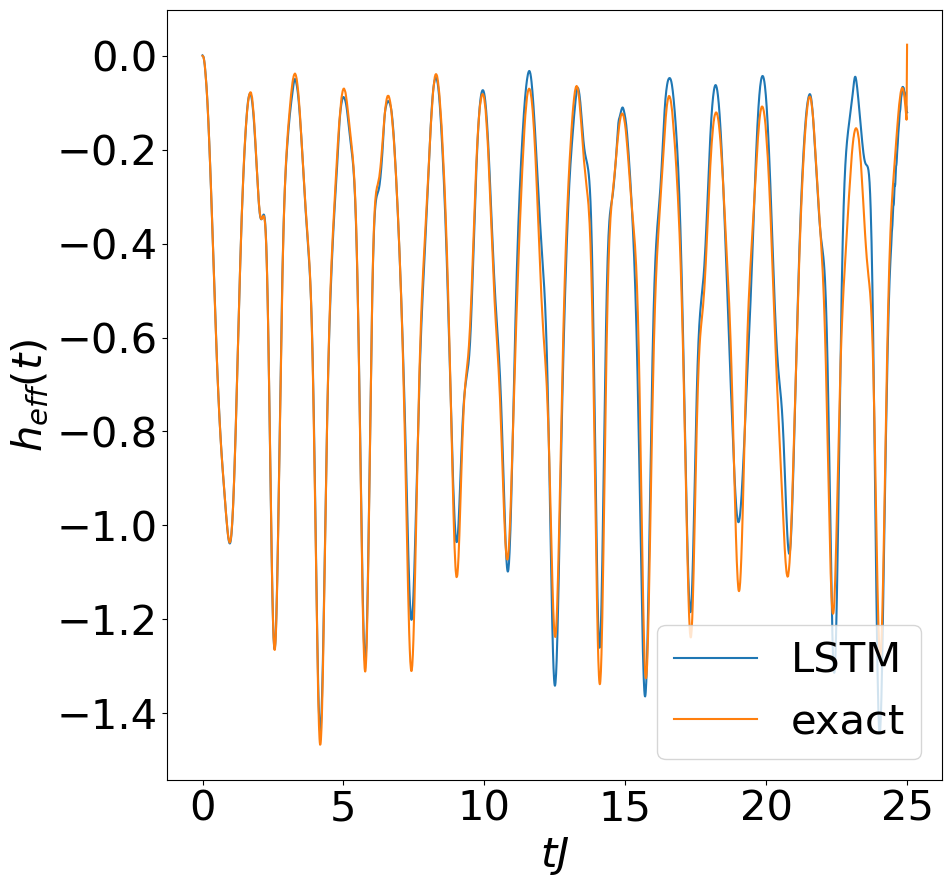

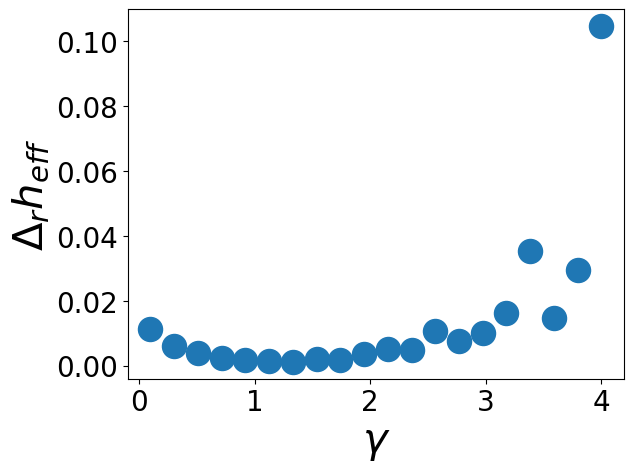

In [497]:
idx=18
print(gammas[idx])
h_eff_predict=h_eff_predictions[idx]
h_eff_vector=h_eff_exacts[idx]
plt.figure(figsize=(10,10))
plt.plot(time,h_eff_predict,label='LSTM')
#plt.plot(time,h_eff_filtered,label='LSTM filtered')
plt.plot(time,h_eff_vector,label='exact')
plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$h_{eff}(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()


plt.scatter(gammas,dh_eff,s=300,marker='o')
plt.xlabel(r'$\gamma$',fontsize=30)
plt.ylabel(r'$\Delta_r h_{eff}$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

3.794736842105263


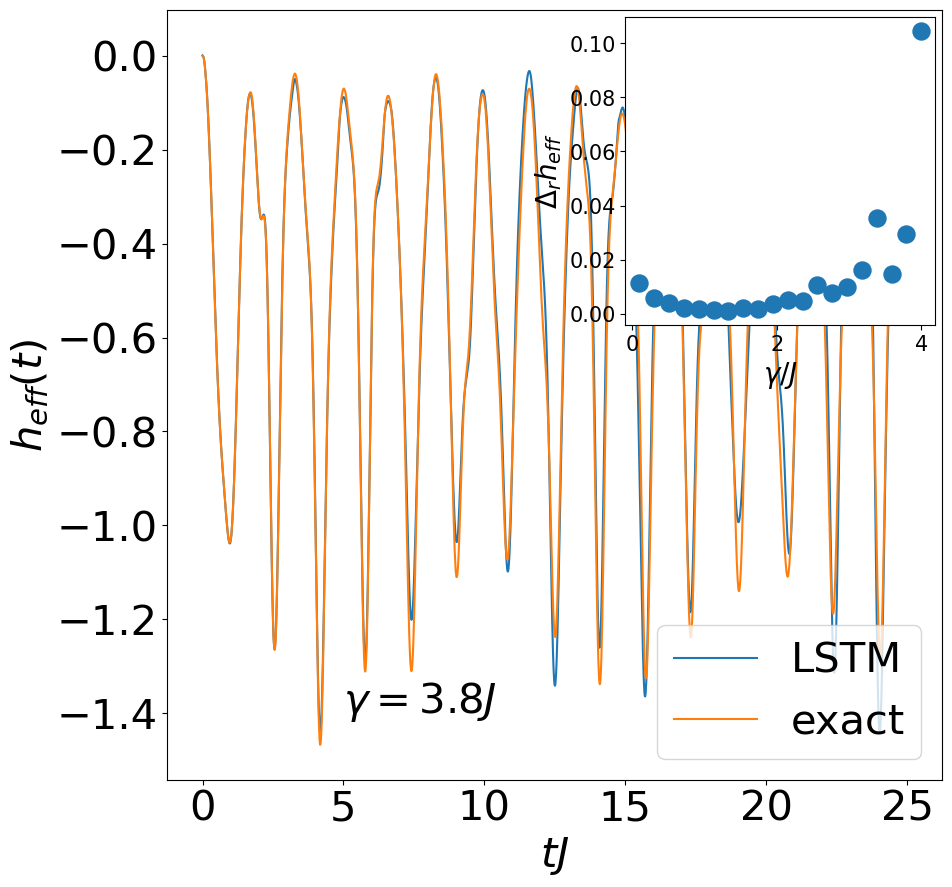

In [501]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

idx = 18
print(gammas[idx])
h_eff_predict = h_eff_predictions[idx]
h_eff_vector = h_eff_exacts[idx]

# Main plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(time, h_eff_predict, label='LSTM')
ax.plot(time, h_eff_vector, label='exact')
ax.set_xlabel(r'$tJ$', fontsize=30)
ax.set_ylabel(r'$h_{eff}(t)$', fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(labelsize=30)
ax.text(x=5,y=-1.4,s=r'$\gamma=3.8 J$',fontsize=30)
# Larger inset plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc='upper right')  # Increase size
inset_ax.scatter(gammas, dh_eff, s=150, marker='o')
inset_ax.set_xlabel(r'$\gamma/J$', fontsize=20)
inset_ax.set_ylabel(r'$\Delta_r h_{eff}$', fontsize=20)
inset_ax.tick_params(labelsize=15)

plt.show()